In [176]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
import joblib
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


In [177]:
def print_scores(y_true, y_pred, model_name):
    print(f"{model_name} Precision: {precision_score(y_true, y_pred):0.2f}")
    print(f"{model_name} Recall: {recall_score(y_true, y_pred):0.2f}")
    print(f"{model_name} F1-Score: {f1_score(y_true, y_pred):0.2f}")

In [178]:
df = pd.read_csv('adult.csv', index_col=0)

In [179]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45170,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
45171,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
45172,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
45173,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [180]:
y = df.pop('income')
X = df

In [181]:
# Extracting catgorical columns
categorical_col = X.select_dtypes(include=['object']).columns.to_list()
categorical_col
encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[categorical_col])

one_hot_X = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_col))

# Concatenate the one-hot encoded dataframe with the original dataframe
X = pd.concat([X, one_hot_X], axis=1)

# Drop the original categorical columns
X = X.drop(categorical_col, axis=1)

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=3, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test, X_val , y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=1, shuffle=True)

In [216]:
X_train.shape

(38398, 104)

In [217]:
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [233]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    # Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  
    metrics=[
        'accuracy'  
    ]
)


early_stopping = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Priotrize class 1
class_weight = {0: 1., 1: 2}

In [234]:
batch_size = 256
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping],
                    class_weight=class_weight)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5933 - loss: 0.8207 - val_accuracy: 0.8280 - val_loss: 0.3949
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.8172 - loss: 0.5204 - val_accuracy: 0.8342 - val_loss: 0.3594
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.8180 - loss: 0.4939 - val_accuracy: 0.8371 - val_loss: 0.3464
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.8289 - loss: 0.4725 - val_accuracy: 0.8368 - val_loss: 0.3440
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.8248 - loss: 0.4708 - val_accuracy: 0.8359 - val_loss: 0.3416
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.8317 - loss: 0.4575 - val_accuracy: 0.8297 - val_loss: 0.3441
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.8296 - loss: 0.4581 - val_accuracy: 0.8362 - val_loss: 0.3365
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.8322 - loss: 0.4

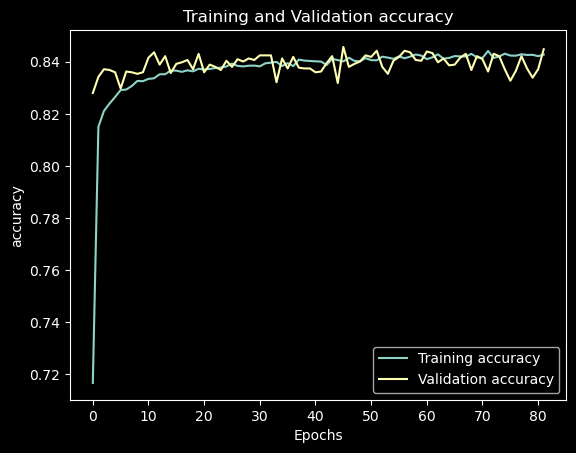

In [235]:
# Extract accuracy values for training and validation
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot accuracy values
plt.plot(accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


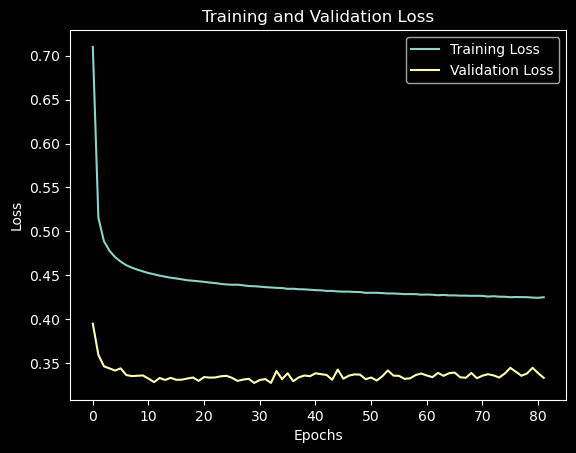

In [236]:
# Extract the loss values for training and validation
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [222]:
results = model.evaluate(X_test, y_test, verbose=1)
y_train_pred_ = model.predict(X_train)
y_val_pred_ = model.predict(X_val)


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8428 - loss: 0.3454
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [223]:
thresholds = [0.3,0.4,0.48,0.5 ,0.55,0.56,0.59, 0.6,0.7]
for threshold in thresholds:
    y_val_pred = (y_val_pred_ > threshold).astype(int).flatten()
    print(f'threshold: {threshold}')
    print_scores(y_val, y_val_pred, 'Neural Network (Validation)')
threshold = 0.5

threshold: 0.3
Neural Network (Validation) Precision: 0.53
Neural Network (Validation) Recall: 0.88
Neural Network (Validation) F1-Score: 0.66
threshold: 0.4
Neural Network (Validation) Precision: 0.58
Neural Network (Validation) Recall: 0.85
Neural Network (Validation) F1-Score: 0.69
threshold: 0.48
Neural Network (Validation) Precision: 0.63
Neural Network (Validation) Recall: 0.80
Neural Network (Validation) F1-Score: 0.71
threshold: 0.5
Neural Network (Validation) Precision: 0.64
Neural Network (Validation) Recall: 0.80
Neural Network (Validation) F1-Score: 0.71
threshold: 0.55
Neural Network (Validation) Precision: 0.68
Neural Network (Validation) Recall: 0.77
Neural Network (Validation) F1-Score: 0.72
threshold: 0.56
Neural Network (Validation) Precision: 0.68
Neural Network (Validation) Recall: 0.76
Neural Network (Validation) F1-Score: 0.71
threshold: 0.59
Neural Network (Validation) Precision: 0.70
Neural Network (Validation) Recall: 0.73
Neural Network (Validation) F1-Score: 

In [224]:
y_train_pred = (y_train_pred_ > threshold).astype(int).flatten()
print(f'threshold: {threshold}')
print_scores(y_train, y_train_pred, 'Neural Network (Train)')

threshold: 0.5
Neural Network (Train) Precision: 0.65
Neural Network (Train) Recall: 0.81
Neural Network (Train) F1-Score: 0.72


In [225]:
y_pred_ = (model.predict(X_test))

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [226]:
print(f'threshold: {threshold}')
y_pred = (y_pred_ > threshold).astype("int32")
print_scores(y_test, y_pred, 'Neural Network (Test)')

threshold: 0.5
Neural Network (Test) Precision: 0.66
Neural Network (Test) Recall: 0.80
Neural Network (Test) F1-Score: 0.72
